# Typhoon Prediction Project
* Predict the trajectory of typhoons
    * 6h, 12h, 18h, 24h, ...
* LSTM, GRU

In [3]:
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import geopandas as gpd
from shapely.geometry import LineString
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pd.set_option('mode.chained_assignment', None)
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available. Training on CPU...')
else:
    device = 'cuda'

In [2]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [88]:
DIR_MAP = {'북': 0, '북동':45, '북서': 315, '북북서':337.5, '북북동':22.5, '서북서':292.5, '서':270, '서남서':247.5, '동북동':67.5, '남서':225,'남남동':157.5, '동남동':112.5, '남남서':202.5, '동':90, '남':180, '남동':157.5, -1:-1}

In [156]:
## 전처리
def rep_nan(data):
    data['진행방향'].fillna(-1, inplace = True)
def drop_str(data):
    cnt=0
    for y,m,d,t in zip(data["Year"],data["Month"],data["Date"],data["Time"]):
            data["Year"][cnt] = y.split("년")[0]
            data["Month"][cnt] = m.split("월")[0]
            data["Date"][cnt] = d.split("일")[0]
            data["Time"][cnt] = t.split("시")[0]
            cnt+=1
    return data
def str2int(data):
    data["Year"]=0
    data["Month"]=0
    data["Date"]=0
    data["Time"]=0
    for i, element in enumerate(data["일시"]):
        data["Year"][i]=element.split(' ')[0]
        data["Month"][i]=element.split(' ')[1]
        data["Date"][i]=element.split(' ')[2]
        data["Time"][i]=element.split(' ')[3]
    return data
def cat_1(data):
    strength_map={}
    for i, s in enumerate(data["강도"].unique()):
        strength_map[s] = i
    data["강도"] = data["강도"].map(strength_map)
    return data
def cat_2(data):
    for i, s in enumerate(data["크기"]):
        if s=="-":
            data["크기"][i] = 0
        elif s=="소형":
            data["크기"][i] = 1
        elif s=="중형":
            data["크기"][i] = 2
        else:
            data["크기"][i] = 3
    return data
def dir_enc(data):
    for i in range(len(data)):
        """
        if data["진행방향"][i-1] == "북":
            if data["진행방향"][i] == "북북동" or "북동" or "동북동" or "동" or "동남동" or "남동" or "남남동"
                 data["진행방향"][i-1] == 0
            else:
                data["진행방향"][i-1] == 360
        """
        data["진행방향"][i] = DIR_MAP[data["진행방향"][i]]
def prepro(data):
    idx = data[data["Unnamed: 1"]!=0].index
    data = data.drop(idx)
    data = data.reset_index()
    data = str2int(data)
    drop_str(data)
    data =cat_1(data)
    data =cat_2(data)
    data = data.drop(["70% 확률 반경(km)", "Unnamed: 1","일시","index"], axis=1)
    rep_nan(data)
    dir_enc(data)
    return data
# def prepro2(data):
#     data = dir_enc(data)

In [90]:
pwd

'C:\\Users\\asy10\\Desktop\\캡스톤'

In [91]:
cd typhoon_pt

C:\Users\asy10\Desktop\캡스톤\typhoon_pt


In [144]:
data_dir = "C:/Users/asy10/Desktop/캡스톤/typhoon_pt/Typhoon/tp_"
data = []

In [145]:
## csv 순서대로읽어와서 data에 저장
for i in range(1,529):
    data.append(pd.read_csv(data_dir+str(i).zfill(3)+".csv",encoding_errors='ignore',encoding="cp949"))

In [146]:
Hin = data[521]
Megi = data[512]
del(data[521])
del(data[512])

In [147]:
for i in range(len(data)):
    data[i]=prepro(data[i])
    #data[i].insert(0,'ID', i)
Hin = prepro(Hin)
Megi = prepro(Megi)

In [148]:
for i in range(len(data)):
    data[i] = data[i].drop(["Year","Month","Date","Time"],axis=1)
Hin = Hin.drop(["Year","Month","Date","Time"],axis=1)
Megi = Megi.drop(["Year","Month","Date","Time"],axis=1)

In [149]:
# for i in range(len(data)):
#     data[i] = data[i].drop(["ID"],axis=1)
# Hin = Hin.drop(["ID"],axis=1)

In [150]:
for i in range(len(data)):
    data[i] = data[i].fillna(-2)

In [99]:
# sc1 = MinMaxScaler()
# sc2 = MinMaxScaler()

# for i in range(len(data)):
#     data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']]=sc1.fit_transform(data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']])
#     data[i][['위도(N)','경도(E)']] = sc2.fit_transform(data[i][['위도(N)','경도(E)']])

In [155]:
data.columns()

AttributeError: 'list' object has no attribute 'columns'

In [100]:
minmax = {}
for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
    m = np.inf
    M = -np.inf
    for i in range(len(data)):
        m = m if np.min(data[i][[j]].values) > m else np.min(data[i][[j]].values)
        # if m == -1 :
            # print(i, end = ' ')
    for i in range(len(data)):
        M = M if np.max(data[i][[j]].values) < M  else np.max(data[i][[j]].values)
    minmax[j] = [m,M]
    print('min', m)
    print('max', M)

min 1.6
max 54.0
min 99.8
max 180.0
min 0
max 1010
min -2.0
max 61
min -4
max 220
min -2.0
max 1480.0
min -2.0
max 216


In [101]:
minmax['위도(N)'][0], minmax['위도(N)'][1] = 0, 60
minmax['경도(E)'][0], minmax['경도(E)'][1] = 90, 180

for i in range(len(data)):
    for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
        data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

# for i in range(len(data)):
#     for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
#         data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

### With_padding

In [102]:
# for i in range(len(data)):
#     pad = nn.ConstantPad2d((0,0,0,max-data[i].shape[0]),0)
#     data[i]=pad(torch.tensor(data[i].values, dtype=torch.float32))

# y=[]
# for i in range(len(data)):
#     y.append(data[i][:,0:2])

# for i in range(len(data)):
#     data[i] = data[i][:,2:]

### Without_padding

In [103]:
y=[]
for i in range(len(data)):
    y.append(pd.concat([data[i][:]['위도(N)'],data[i][:]['경도(E)']],axis=1))

for i in range(len(data)):
    data[i] = data[i].drop(['위도(N)','경도(E)'], axis=1)

for i in range(len(data)):
    data[i] = torch.tensor(data[i].values, dtype=torch.float32)
    y[i] = torch.tensor(y[i].values, dtype=torch.float32)


In [104]:
y[0]

tensor([[0.3000, 0.3233],
        [0.3233, 0.3400],
        [0.3683, 0.3633]])

In [105]:
x_train, x_valid, y_train, y_valid = train_test_split(data, y, test_size=0.1,shuffle=False)

# 전처리 끝

In [106]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]
    
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=10)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=10)
    
    return xx_pad, yy_pad

In [107]:
class my_dataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.target = y
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, i):
        return self.data[i], self.target[i]

In [108]:
batch_size = 32
input_size = 8
hidden_size = 128
num_layer = 2
output_size = 2
MAX_LENGTH = 74
# embedding_size = 32

In [109]:
train_dataset = my_dataset(x_train, y_train)
valid_dataset = my_dataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False, collate_fn = pad_collate)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, collate_fn = pad_collate)

### Encoder

In [110]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,num_layer,batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        self.gru = nn.GRU(input_size, hidden_size,num_layer, batch_first=True)
        
        self.ln = nn.LayerNorm(hidden_size)
         
        self.dropout= nn.Dropout(0.3)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        # output = self.ln(output)
        
        hidden = self.ln(hidden)

        return output, hidden
        
    def initHidden(self,num_layer,batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

### Attention

1. 인코더의 히든 스테이트(h1~h32)들을 스텝별로 구한다. -> encoder_hiddens 

2. 디코더의 이전 스텝 히든 스테이트들을 encoder_hiddens에 각각 내적해서 어텐션 가중치를 만든다. 

3. 어텐션 가중치를 소프트맥스한다. 

4. 소프트맥스 된 점수에 해당하는 각각의 히든 스테이트들에 어텐션 가중치를 곱한다
 
5. 점수에 곱해진 vector들을 sum up 한다 -> context vector 


In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
               
        self.attn = nn.Linear((enc_hidden_dim  + dec_hidden_dim), dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, enc_outputs):
        
        # enc_outputs: [피처 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 태풍의 출력 정보
        batch_size = enc_outputs.shape[1]
        src_len = enc_outputs.shape[0]
        
        # 현재 디코더의 히든 상태(hidden state)를 src_len만큼 반복
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        enc_outputs = enc_outputs.permute(1, 0, 2)
        
        # energy: [배치 크기, 피처 개수, 디코더 히든 차원]
        energy = torch.tanh(self.attn(torch.cat((hidden, enc_outputs), dim=2)))
        
        # attention: [배치 크기, 피처 개수]: 피처에 대한 어텐선(attention) 값들
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

### AttentionDecoder

In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, decoder_input_size, enc_hidden_dim, dec_hidden_dim, output_size, batch_size, dropout_p=0.1):
        super(AttnDecoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        
        self.attention = attention 
        
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        
        self.output_size = output_size
        self.batch_size = batch_size
        self.dropout_p = dropout_p
        
        self.gru = nn.GRU(decoder_input_size,hidden_size,batch_first=True)
        self.out = nn.Linear((self.enc_hidden_dim  + self.dec_hidden_dim), self.output_size)
        
    def forward(self, input, hidden, enc_outputs):
        # input : [배치크기, 레이어 개수, 피처개수(2,위도, 경도)]
        # hidden : [레이어 개수, 배치 크기, 히든 차원 ] - 수정? 
        # enc_outputs: [피처 개수(8), 배치 크기, 인코더 히든 차원 * 방향의 수]: 전체 태풍의 출력 정보
        
        #피처 개수는 항상 1개이도록 구현 한다.
        input = input.squeeze(0) 
        
        #attention : [배치 크기 , 피처 개수] : 각 피처에 대한 어텐션 값들 
        attention = self.attention(hidden, enc_outputs)
        
        attention = attention.squeeze(1)
        
        #enc_outputs [배치 크기, 피처 개수, 인코더 히든 차원 * 방향의 수] : 전체 태풍의 출력 정보 
        enc_outputs = enc_outputs.permute(1,0,2) # 텐서의 차원 순서 변경 
        
        # weighted: [배치 크기, 레이어 개수, 인코더 히든 차원 * 방향의 수]
        weighted = torch.bmm(attention, enc_outputs) # 행렬 곱 함수 
        
        # weighted: [레이어 개수, 배치 크기, 인코더 히든 차원 * 방향의 수]
        weighted = weighted.permute(1,0,2)
        
        # decoder_input : [1, 배치 크기, 인코더 히든 차원 * 방향의 수 ] : 어텐션이 적용된 현재 위도,경도 정보
        decoder_input = torch.cat((input, weighted), dim = 2) 
        
        
        #output: [피처 개수, 배치 크기, 디코더 히든 차원 * 방향의 수]
        # hidden: [레이어 개수 * 방향의 수, 배치 크기, 디코더 히든 차원]: 현재까지의 모든 위도, 경도 정보
        output, hidden = self.gru(decoder_input, hidden.unsqueeze(0))
        
        ouput = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.out(torch.cat((output,weighted), dim = 1))
        
        return prediction , hidden.squeeze(0)
        

### Decoder

In [111]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, num_layer, batch_size):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layer = num_layer
        
        self.gru = nn.GRU(output_size, hidden_size,num_layer, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.ln = nn.LayerNorm(hidden_size)
        
        self.relu = nn.ReLU(True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.bn = nn.InstanceNorm1d(hidden_size)
        
        #self.bn = nn.BatchNorm1d(hidden_size)
        
    def forward(self, input, hidden):
        
        output, hidden = self.gru(input, hidden)
        
        # hidden = self.ln(hidden)
        output = self.ln(output)
        
        output = self.relu(self.bn(self.fc1(output)))
        
        output = self.dropout(output)
        
        output = self.fc2(output)
        
        output = self.relu(output)
        
        return output, hidden
    
    def initHidden(self, num_layer, batch_size):
        return torch.zeros(num_layer,batch_size,self.hidden_size)

## Bi

### Linear

In [114]:
encoder = EncoderRNN(input_size, hidden_size, num_layer, batch_size)
decoder = DecoderRNN(output_size, hidden_size, num_layer, batch_size)

In [115]:
encoder

EncoderRNN(
  (gru): GRU(8, 128, num_layers=2, batch_first=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [116]:
decoder

DecoderRNN(
  (gru): GRU(2, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

In [117]:
def mse_loss(data, target, ignored_index):
    mask = (target == ignored_index)
    o_loss = nn.MSELoss(reduction = 'mean')
    m_data = data[~mask]
    m_target = target[~mask]
    loss = o_loss(m_data, m_target)
    return loss

In [ ]:
batch_size = 32
input_size = 8
hidden_size = 128
num_layer = 2
output_size = 2
MAX_LENGTH = 74
# embedding_size = 32

In [182]:
epoch = 200
teacher_forcing_ratio = 0.5
learning_rate = 0.001
# embeder = Emb(hidden_size, output_size)
encoder.to(device)
decoder.to(device)
# embeder.to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
# embeder_optimizer = optim.Adam(embeder.parameters(), lr = learning_rate)
# scheduler1 = optim.lr_scheduler.StepLR(encoder_optimizer,step_size=400,gamma=0.1,verbose=True)
# scheduler2 = optim.lr_scheduler.StepLR(decoder_optimizer,step_size=400,gamma=0.1,verbose=True)

criterion = mse_loss

# Save training loss
train_loss = torch.zeros(epoch)
valid_loss_min = np.Inf
# Save validation loss
valid_loss = torch.zeros(epoch)
for e in trange(epoch):
    encoder.train()
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        # print(type(data))

        encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
        encoder_hidden = encoder_hidden.to(device)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # embeder_optimizer.zero_grad()
        
        input_length = data.size(1)
        target_length = label.size(1)
        
        print("encoder hidden size  : ",encoder.hidden_size)
        
        encoder_hiddens = torch.zeros(input_length, encoder.hidden_size).to(device) # attention weight calcul 
        print(input_length)
        print("encoder hiddens : " , encoder_hiddens.shape) # num_layer, batch_size, hidden_size 
        
        print("encoder hidden : " , encoder_hidden.shape)
        # Encoder
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
            encoder_hiddens[i] = encoder_hidden[0]
        
        # Decoder_init
        d_input = torch.zeros((label.shape[0],1,2)).to(device)
        decoder_input = label[:,0,:].reshape(label.shape[0],1,-1)#d_input
        # print(decoder_input.shape)
        decoder_hidden = encoder_hidden
        # print(decoder_hidden.shape)
        
        # Decoder
        for di in range(1,target_length):
            # print(decoder_input.size(), decoder_hidden.size())
            # print(decoder_input.size(), decoder_hidden.size())
            decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
            
            # print(decoder_input[:,di,:].shape, label[:,di,:].reshape(1,1,-1).shape)
            # output = embeder(decoder_output)
            # print(output.shape)
            # teacher_force = random.random() < teacher_forcing_ratio
            loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
            decoder_input = label[:,di,:].reshape(label.shape[0],1,-1) #if teacher_force else decoder_output
            # print(decoder_output.shape)
            train_loss[e] += loss.item()
        loss.backward(retain_graph = True)
        encoder_optimizer.step()
        decoder_optimizer.step()
        # embeder_optimizer.step()
    train_loss[e] /= len(train_loader)

    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        # embeder.eval()
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            
            encoder_hidden = encoder.initHidden(num_layer,label.shape[0])
            encoder_hidden = encoder_hidden.to(device)

            # encoder_optimizer.zero_grad()
            # decoder_optimizer.zero_grad()
            # embeder_optimizer.zero_grad()

            input_length = data.size(1)
            target_length = label.size(1)

            # encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)

            for ei in range(input_length):
                
                # print(data.size(), encoder_hidden.size())
                encoder_output, encoder_hidden = encoder(data[:,ei,:].reshape(label.shape[0],1,-1), encoder_hidden)
                # print(1)
                # encoder_outputs[ei] += encoder_output[0,0]

            d_input = torch.zeros((label.shape[0],1,2)).to(device)
            decoder_input = label[:,0,:].reshape(label.shape[0],1,-1)
            decoder_hidden = encoder_hidden

            for di in range(1,target_length):
                
                decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
                # print(decoder_output.shape, decoder_hidden.shape, label.shape)
                # output = embeder(decoder_output)
                # teacher_force = random.random() < teacher_forcing_ratio
                loss=criterion(decoder_output, label[:,di,:].reshape(label.shape[0],1,-1),ignored_index=10)
                decoder_input = label[:,di,:].reshape(label.shape[0],1,-1)# if teacher_force else decoder_output
                valid_loss[e] += loss.item()
        valid_loss[e] /= len(valid_loader)
        # scheduler1.step()
        # scheduler2.step()
    print(f'Epoch : {e},\ttrain_loss : {train_loss[e]}\tvalid_loss :{valid_loss[e]}')
    if (valid_loss[e] <= valid_loss_min):
        print(f'**********Valid loss decreased ({valid_loss_min:.6f} ==> {valid_loss[e]:.6f})**********')
        valid_loss_min = valid_loss[e]
        torch.save(encoder.state_dict(),'Encoder{}.pt'.format(e))
        torch.save(decoder.state_dict(),'Decoder{}.pt'.format(e))

  0%|          | 0/200 [00:00<?, ?it/s]

encoder hidden size  :  128
34
encoder hiddens :  torch.Size([34, 128])
encoder hidden :  torch.Size([2, 32, 128])


IndexError: index 43 is out of bounds for dimension 0 with size 34

([<matplotlib.lines.Line2D at 0x20950f4e4f0>],
 [<matplotlib.lines.Line2D at 0x20950f4ed60>])

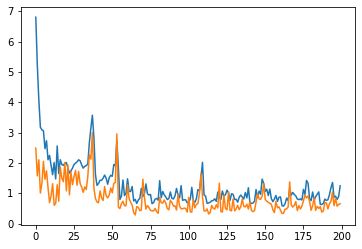

In [119]:
plt.plot(train_loss),plt.plot(valid_loss)

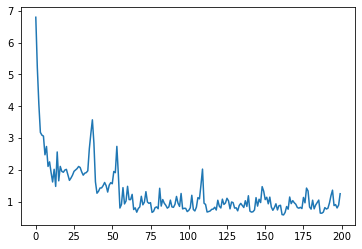

In [120]:
plt.plot(train_loss)

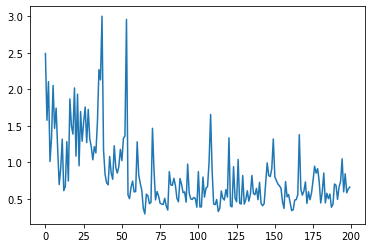

In [121]:
plt.plot(valid_loss)

In [122]:
Hin_X = Hin.drop(['위도(N)','경도(E)'],axis=1)
Hin_Y = pd.concat([Hin['위도(N)'],Hin['경도(E)']],axis=1)

Megi_X = Megi.drop(['위도(N)','경도(E)'],axis=1)
Megi_Y = pd.concat([Megi['위도(N)'],Megi['경도(E)']],axis=1)

In [123]:
for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','이동속도(km/h)']:
        Hin_X[j] = (Hin_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
        Megi_X[j] = (Megi_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [124]:
for j in ['위도(N)','경도(E)']:
    Hin_Y[j] = (Hin_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])
    Megi_Y[j] = (Megi_Y[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [125]:
Hin_X=Hin_X.values.reshape(-1,44,8).astype(np.float32)
Megi_X=Megi_X.values.reshape(-1,9,8).astype(np.float32)
Hin_Y=Hin_Y.values.reshape(-1,44,2).astype(np.float32)
Megi_Y=Megi_Y.values.reshape(-1,9,2).astype(np.float32)

In [126]:
Hin_X = torch.tensor(Hin_X, dtype=torch.float32)
Megi_X = torch.tensor(Megi_X, dtype=torch.float32)
Hin_Y = torch.tensor(Hin_Y, dtype=torch.float32)
decoder_inputg = Hin_Y[:,0,:].to(device)
Megi_Y = torch.tensor(Megi_Y, dtype=torch.float32)
decoder_inputm = Megi_Y[:,0,:].to(device)

In [127]:
Hin_X.shape

torch.Size([1, 44, 8])

In [157]:
pwd

'C:\\Users\\asy10\\Desktop\\캡스톤\\typhoon_pt'

In [158]:
# encoder = EncoderRNN(input_size,hidden_size,batch_size)
# decoder = DecoderRNN()
encoder.load_state_dict(torch.load('../Encoder94.pt'))
decoder.load_state_dict(torch.load('../Decoder94.pt'))

<All keys matched successfully>

In [159]:
Hin_X = Hin_X.to(device)
hid = encoder.initHidden(2,1)
hid = hid.to(device)
# encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size).to(device)
decode_path = []
# given_path = []
for i in range(Hin_X.shape[1]):
    out, hidden = encoder(Hin_X[:,i,:].reshape(1,1,-1),hid)
    # given_path.append(Hin_Y[:,i,:].reshap(1,1,-1))
    # encoder_outputs[i] += out[0,0]
d_input = torch.zeros((1,1,2)).to(device)
decoder_input = decoder_inputg.reshape(1,-1,2) #d_input
decode_path.append(decoder_input)
decoder_hidden = hidden

# decode_path.append(decoder_input)
for i in range(1,Hin_X.shape[1]):
    decoder_output , decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = Hin_Y[:,i,:].reshape(1,1,-1).to(device)#decoder_output#
    decode_path.append(decoder_output)

In [160]:
len(decode_path)

44

In [161]:
decode_path[0].squeeze()[0].item()#.to('cpu').detach().numpy()

0.4483333230018616

In [162]:
path_x=[]
path_y=[]
for i in range(len(decode_path)):
    path_x.append(decode_path[i].squeeze()[0].item()* (minmax['위도(N)'][1] - minmax['위도(N)'][0]) + minmax['위도(N)'][0])
    path_y.append(decode_path[i].squeeze()[1].item()* (minmax['경도(E)'][1] - minmax['경도(E)'][0]) + minmax['경도(E)'][0])

In [163]:
# path_x=[]
# path_y=[]
# for i in range(len(decode_path)):
#     path_x.append(decode_path[i].squeeze()[0].item())
#     path_y.append(decode_path[i].squeeze()[1].item())

In [164]:
path_y[0]

148.4999978542328

In [165]:
path_x = pd.DataFrame(path_x)
path_y = pd.DataFrame(path_y)

In [166]:
pred1_path = pd.concat([path_x, path_y],axis=1)

In [167]:
pred1_path.columns=['위도','경도']

In [168]:
pred1_path

,위도,경도
0,26.899999,148.499998
1,48.833063,126.323918
2,49.269269,120.856771
3,48.454463,127.850867
4,44.261642,138.355374
5,38.433198,144.743355
6,33.470950,146.526831
7,29.976861,145.363685
8,27.977883,143.348488
9,27.063485,140.832378


In [169]:
pred1_path

,위도,경도
0,26.899999,148.499998
1,48.833063,126.323918
2,49.269269,120.856771
3,48.454463,127.850867
4,44.261642,138.355374
5,38.433198,144.743355
6,33.470950,146.526831
7,29.976861,145.363685
8,27.977883,143.348488
9,27.063485,140.832378


In [170]:
Megi_Y

tensor([[[0.1817, 0.3989],
         [0.1817, 0.3933],
         [0.1833, 0.3911],
         [0.1833, 0.3889],
         [0.1833, 0.3867],
         [0.1833, 0.3833],
         [0.1883, 0.3844],
         [0.1850, 0.3889],
         [0.1850, 0.3978]]])

C:\Users\asy10\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

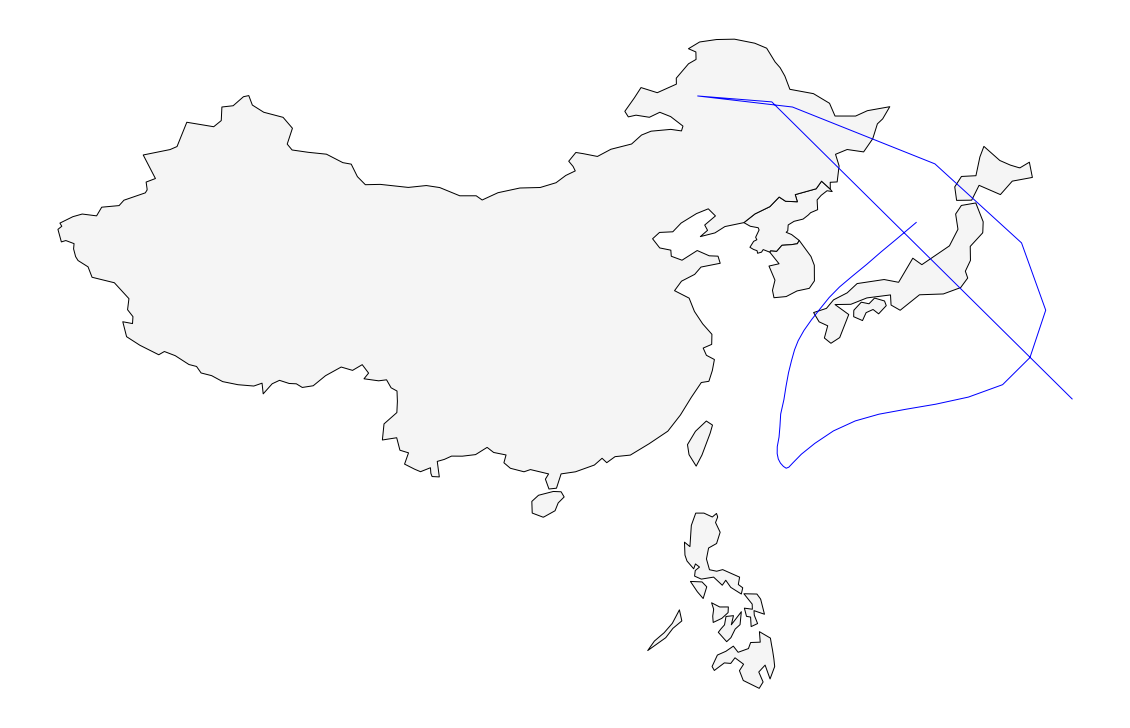

In [171]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='blue', zorder=1)

C:\Users\asy10\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

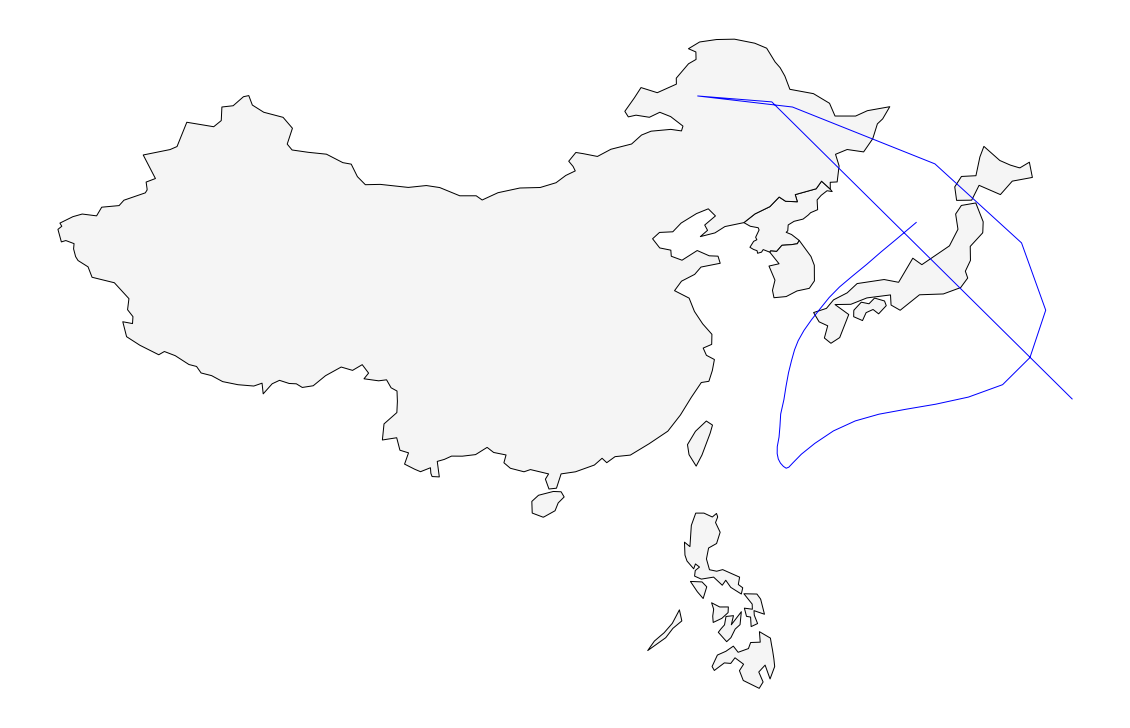

In [172]:
gdf_path = gpd.GeoDataFrame(pred1_path, geometry=gpd.points_from_xy(pred1_path[:]['경도'],pred1_path[:]['위도']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='blue', zorder=1)

In [173]:
gdf_path = gpd.GeoDataFrame(Hin_Y, geometry=gpd.points_from_xy(Hin_Y[:]['경도(E)'],Hin_Y[:]['위도(N)']), crs='epsg:4326')
line_geometry = LineString(gdf_path["geometry"])
df_path_line = pd.DataFrame({'geometry' : [line_geometry]})
gdf_path_line = gpd.GeoDataFrame(df_path_line, geometry=df_path_line.geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basemap = world.loc[world['name'].isin(['South Korea', 'North Korea','Japan', 'China', 'Philippines','Taiwan'])]
ax = basemap.plot(figsize=(20,20), color='whitesmoke', edgecolor='black', linewidth=1)
ax.axis('off')
gdf_path_line.plot(ax=ax, linewidth=1., color='b', zorder=1)

IndexError: too many indices for tensor of dimension 3